In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-dataset/vehicles/7981.jpg
/kaggle/input/cnn-dataset/vehicles/6234.jpg
/kaggle/input/cnn-dataset/vehicles/1269.jpg
/kaggle/input/cnn-dataset/vehicles/3863.jpg
/kaggle/input/cnn-dataset/vehicles/6241.jpg
/kaggle/input/cnn-dataset/vehicles/623.jpg
/kaggle/input/cnn-dataset/vehicles/2193.jpg
/kaggle/input/cnn-dataset/vehicles/3750.jpg
/kaggle/input/cnn-dataset/vehicles/2008.jpg
/kaggle/input/cnn-dataset/vehicles/5982.jpg
/kaggle/input/cnn-dataset/vehicles/7737.jpg
/kaggle/input/cnn-dataset/vehicles/2081.jpg
/kaggle/input/cnn-dataset/vehicles/6588.jpg
/kaggle/input/cnn-dataset/vehicles/7966.jpg
/kaggle/input/cnn-dataset/vehicles/3919.jpg
/kaggle/input/cnn-dataset/vehicles/6197.jpg
/kaggle/input/cnn-dataset/vehicles/6399.jpg
/kaggle/input/cnn-dataset/vehicles/9960.jpg
/kaggle/input/cnn-dataset/vehicles/3757.jpg
/kaggle/input/cnn-dataset/vehicles/9131.jpg
/kaggle/input/cnn-dataset/vehicles/9620.jpg
/kaggle/input/cnn-dataset/vehicles/9062.jpg
/kaggle/input/cnn-dataset/vehicle

## Part 3: CNN Dataset

### Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
import time
import os
from PIL import Image
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


### Find the mean and std of the dataset

In [3]:
normalize_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create a dataset object with the normalization transform
dataset = datasets.ImageFolder('/kaggle/input/cnn-dataset/', transform=normalize_transform)

# Calculate the mean and standard deviation of the dataset for all three channels
mean = 0.0
std = 0.0
num_samples = len(dataset)

for x, _ in dataset:
    # Sum over all channels and all pixels
    mean += torch.mean(x, dim=(1,2))
    std += torch.std(x, dim=(1,2))

# Divide by the number of samples to get the final mean and standard deviation
mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5047, 0.4501, 0.3840])
Std: tensor([0.2386, 0.2384, 0.2404])


### Transform the dataset and create dataloader objects

In [4]:
data_dir = '/kaggle/input/cnn-dataset/'

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5047, 0.4501, 0.3840], std=[0.2386, 0.2384, 0.2404])
])


# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader objects for the train and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### Visualization 1 : Print some random images from a class

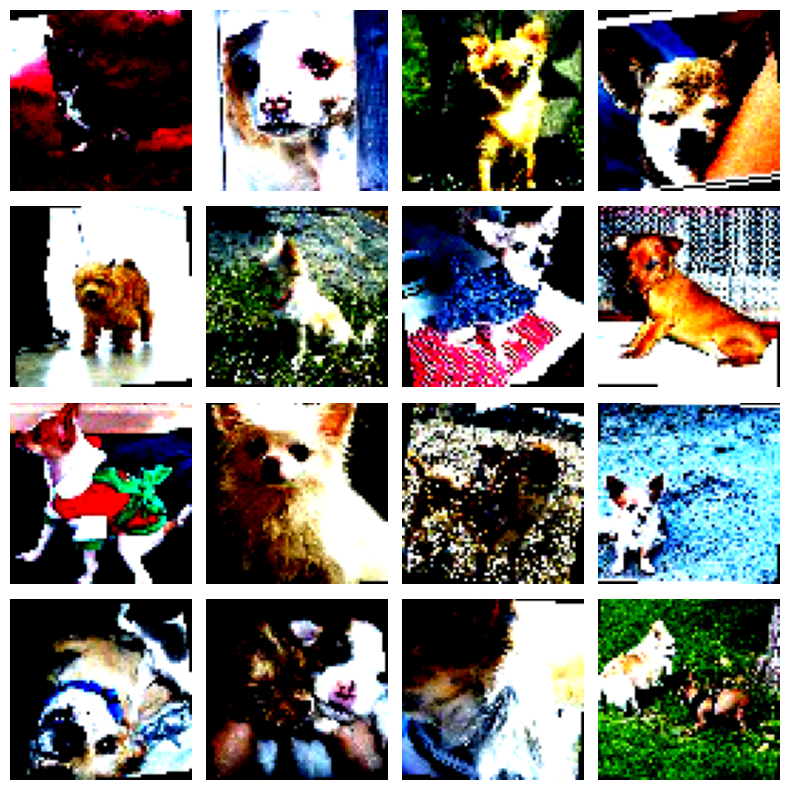

In [5]:
# VIS 1
samples = [dataset[i][0] for i in range(16)]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].permute(1, 2, 0), vmin=0, vmax=1)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Visualization 2: Scatterplot of pixels for random image

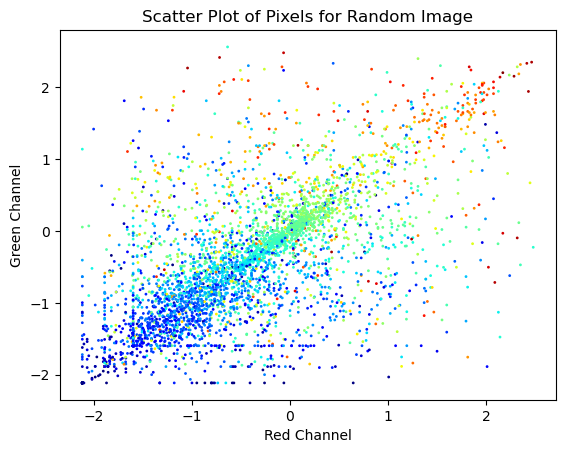

In [6]:
# VIS 2

# Select a random image from the dataset
idx = torch.randint(len(dataset), size=(1,)).item()
image, _ = dataset[idx]

# Reshape the image into a 2D array of pixels
pixels = image.view(-1, 3).numpy()

# Create a scatter plot of the pixels
plt.scatter(pixels[:, 0], pixels[:, 1], s=1, c=pixels[:, 2], cmap="jet")
plt.title("Scatter Plot of Pixels for Random Image")
plt.xlabel("Red Channel")
plt.ylabel("Green Channel")
plt.show()


### Visualization 3: Histogram of pixel intensities for a random image

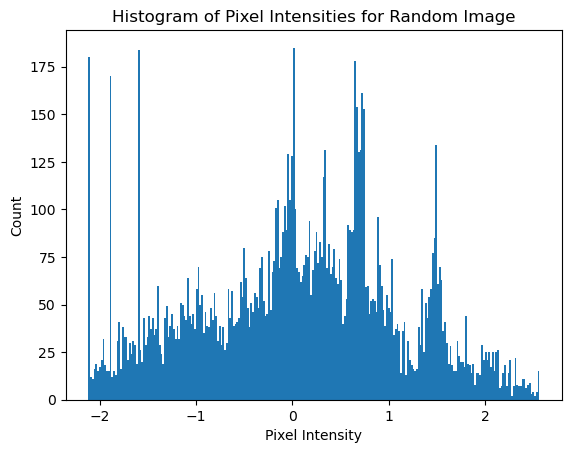

In [9]:
# VIS 3
idx = torch.randint(len(dataset), size=(1,)).item()
image, _ = dataset[idx]

# Flatten the image tensor into a 1D array of pixel intensities
pixels = image.view(-1)

# Plot a histogram of the pixel intensities
plt.hist(pixels, bins=256)
plt.title("Histogram of Pixel Intensities for Random Image")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.show()

### Visualization 4: Number of samples per class

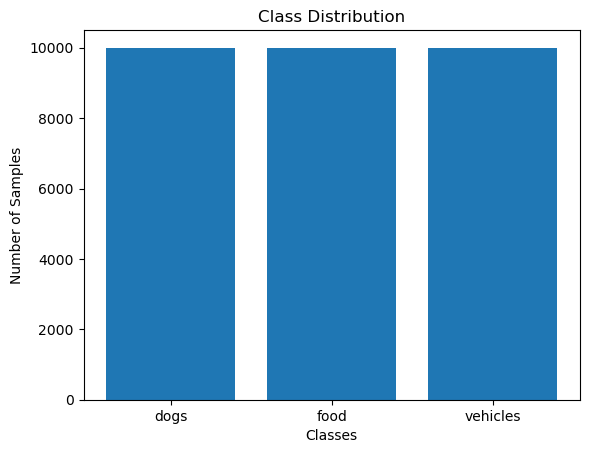

In [10]:
# VIS 4
num_samples = [len(np.array(dataset.targets)[np.array(dataset.targets) == i]) for i in range(len(dataset.classes))]

# Create a bar chart of the class distribution
fig, ax = plt.subplots()
ax.bar(dataset.classes, num_samples)
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution')
plt.show()

### Define basic AlexNet class

In [11]:
# Define AlexNet
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


### Define Train, Test, and Plot functions

In [12]:
# Train the model
def train_model(num_epochs,model,train_loader,val_loader, criterion, optimizer, device):
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    start_time  = time.time()
    for epoch in range(num_epochs):
        print("Training Model...")
        running_loss = 0.0
        train_correct = 0.0
        train_total = 0
        model.train()
        for i, data in enumerate(train_loader, 0):
            # Get the inputs and labels from the dataloader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, train_predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (train_predicted == labels).sum().item()

        # Validation

        val_running_loss = 0
        val_acc = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move validation inputs and labels to device
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_running_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (val_predicted == val_labels).sum().item()
                        
        val_running_loss = val_running_loss/len(val_loader.dataset)
        val_loss_list.append(val_running_loss)
        val_acc = correct/total
        val_acc_list.append(val_acc)
        running_loss = running_loss/len(train_loader.dataset)
        train_loss_list.append(running_loss)
        train_acc = train_correct/train_total
        train_acc_list.append(train_acc)

        print(f'Epoch : {epoch}, train_loss = {running_loss}, train_acc = {round(train_acc*100,3)}, val_loss = {val_running_loss}, val_acc = {round(val_acc*100,3)}')
    
    # return running_loss,train_acc,val_running_loss,val_acc
    end_time  = time.time()
    elapsed_time = end_time - start_time
    print("Training time in seconds : ",elapsed_time)
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


def test_model(model, test_loader, device):

# Evaluate the model on the test set
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move test inputs and labels to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct/total

    print('Test Accuracy = ', test_accuracy)
    return test_accuracy

def plots(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_loss_list, label='Training Loss')
    axs[0].plot(val_loss_list, label='Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training loss vs Validation Loss')
    axs[0].legend()
#     axs[0].set_ylim([0.0001, 0.01]) # set y-limits for loss plot
    axs[1].plot(train_acc_list, label='Training Accuracy')
    axs[1].plot(val_acc_list, label='Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training Accuracy vs Validation Accuracy')
    axs[1].legend()
#     axs[1].set_ylim([0.5, 1.0])

In [13]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
num_epochs = 20

In [14]:
train_loss_list, train_acc_list, val_loss_list, val_acc_list = train_model(num_epochs,model,train_loader,val_loader, criterion, optimizer, device)

Training Model...
Epoch : 0, train_loss = 0.008499602487931648, train_acc = 77.358, val_loss = 0.006212570957839489, val_acc = 84.817
Training Model...
Epoch : 1, train_loss = 0.0059145859982818365, train_acc = 85.204, val_loss = 0.005836747713387012, val_acc = 85.4
Training Model...
Epoch : 2, train_loss = 0.005245551307996114, train_acc = 87.112, val_loss = 0.005168160873154799, val_acc = 87.367
Training Model...
Epoch : 3, train_loss = 0.004891865604246656, train_acc = 87.904, val_loss = 0.004565863691270352, val_acc = 89.217
Training Model...
Epoch : 4, train_loss = 0.004515036313794553, train_acc = 88.763, val_loss = 0.004672731970747312, val_acc = 88.683
Training Model...
Epoch : 5, train_loss = 0.004274812192035218, train_acc = 89.5, val_loss = 0.004663347590714693, val_acc = 89.317
Training Model...
Epoch : 6, train_loss = 0.004014253268639247, train_acc = 90.254, val_loss = 0.004315768111497164, val_acc = 89.917
Training Model...
Epoch : 7, train_loss = 0.0038416061693181593, 

In [15]:
orig_test_accuracy = test_model(model, test_loader, device)

Test Accuracy =  90.68333333333334


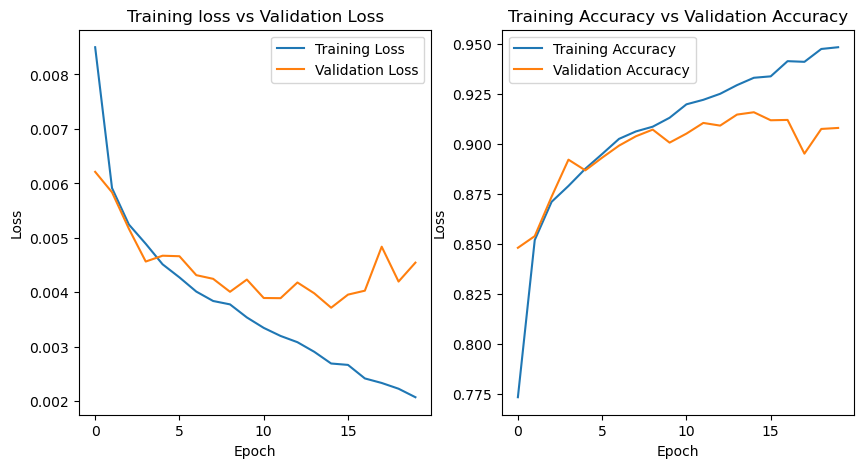

In [16]:
plots(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

### Run the same model with learning rate 0.001

In [17]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = AlexNet(num_classes=3).to(device)
optimizer = optim.Adam(model1.parameters(),lr=0.001)
num_epochs = 20

In [18]:
train_loss_list1, train_acc_list1, val_loss_list1, val_acc_list1 = train_model(num_epochs,model1,train_loader,val_loader, criterion, optimizer, device)

Training Model...
Epoch : 0, train_loss = 0.009505969482163588, train_acc = 75.513, val_loss = 0.006868432566523552, val_acc = 82.9
Training Model...
Epoch : 1, train_loss = 0.007296544230232636, train_acc = 82.479, val_loss = 0.007658500085274378, val_acc = 82.617
Training Model...
Epoch : 2, train_loss = 0.006285841319710017, train_acc = 85.054, val_loss = 0.0053135679985086125, val_acc = 87.583
Training Model...
Epoch : 3, train_loss = 0.005851177503044406, train_acc = 86.004, val_loss = 0.0055963355526328085, val_acc = 87.283
Training Model...
Epoch : 4, train_loss = 0.005555227231234312, train_acc = 86.754, val_loss = 0.0054338249762852986, val_acc = 87.317
Training Model...
Epoch : 5, train_loss = 0.005428480979676048, train_acc = 87.117, val_loss = 0.005107640532155832, val_acc = 88.067
Training Model...
Epoch : 6, train_loss = 0.005319656592483322, train_acc = 87.371, val_loss = 0.004767428295065959, val_acc = 88.383
Training Model...
Epoch : 7, train_loss = 0.00524418320817252

In [19]:
test_accuracy1 = test_model(model1, test_loader, device)

Test Accuracy =  89.91666666666667


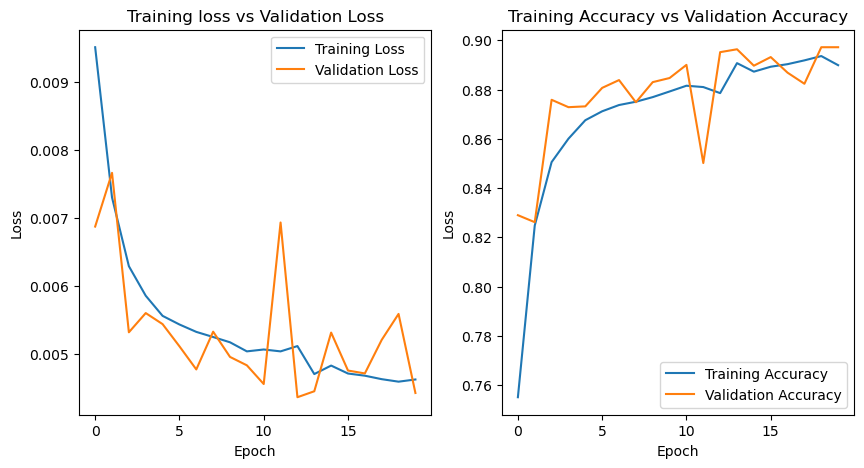

In [20]:
plots(train_loss_list1, train_acc_list1, val_loss_list1, val_acc_list1)

### Add dropout probability 0.4 to the original model

In [21]:
# Add dropout 0.4 to the AlexNet
class D_AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(D_AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [22]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = D_AlexNet(num_classes=3).to(device)
optimizer = optim.Adam(model2.parameters(),lr=0.0001)
num_epochs = 20

In [23]:
train_loss_list2, train_acc_list2, val_loss_list2, val_acc_list2 = train_model(num_epochs,model2,train_loader,val_loader, criterion, optimizer, device)

Training Model...
Epoch : 0, train_loss = 0.00892075999143223, train_acc = 76.096, val_loss = 0.0061573751841982206, val_acc = 84.35
Training Model...
Epoch : 1, train_loss = 0.005997083927815159, train_acc = 85.138, val_loss = 0.005213862416644891, val_acc = 87.7
Training Model...
Epoch : 2, train_loss = 0.005383851005074878, train_acc = 86.787, val_loss = 0.004992943828304609, val_acc = 88.483
Training Model...
Epoch : 3, train_loss = 0.004993429178682466, train_acc = 87.621, val_loss = 0.004737536502381166, val_acc = 88.667
Training Model...
Epoch : 4, train_loss = 0.0045691862475747864, train_acc = 88.7, val_loss = 0.004792016821602981, val_acc = 88.167
Training Model...
Epoch : 5, train_loss = 0.004391729238753517, train_acc = 89.279, val_loss = 0.004199897979696591, val_acc = 89.817
Training Model...
Epoch : 6, train_loss = 0.004095399373831849, train_acc = 90.058, val_loss = 0.0044018571376800535, val_acc = 89.667
Training Model...
Epoch : 7, train_loss = 0.00385822494328022, tr

In [24]:
test_accuracy2 = test_model(model2, test_loader, device)

Test Accuracy =  91.51666666666667


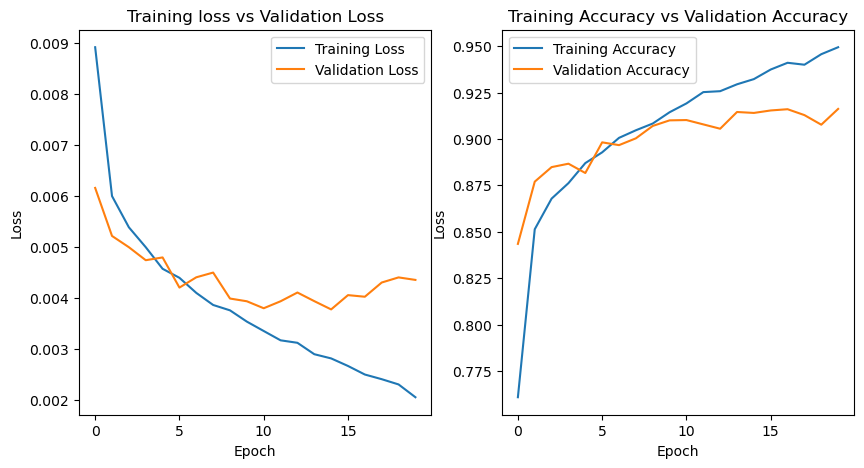

In [25]:
plots(train_loss_list2, train_acc_list2, val_loss_list2, val_acc_list2)

### Add Batch Normalization and L2 Regularization to AlexNet

In [26]:

class BL2AlexNet(nn.Module):
    def __init__(self, num_classes=3, reg_lambda=0.01):
        super(BL2AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.reg_lambda = reg_lambda

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        # L2 regularization
        l2_reg = torch.tensor(0.).to(x.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        
        return x - self.reg_lambda * l2_reg


In [27]:
# Modify the train function to include the L2 regularization
def l2_train_model(num_epochs,model,train_loader,val_loader, criterion, optimizer, device):
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    start_time  = time.time()
    for epoch in range(num_epochs):
        print("Training Model...")
        running_loss = 0.0
        train_correct = 0.0
        train_total = 0
        model.train()
        for i, data in enumerate(train_loader, 0):
            # Get the inputs and labels from the dataloader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l2_loss = 0
            for param in model.parameters():
                l2_loss += torch.sum(param.pow(2))
            loss += l2_reg * l2_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, train_predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (train_predicted == labels).sum().item()

        # Validation

        val_running_loss = 0
        val_acc = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move validation inputs and labels to device
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_running_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (val_predicted == val_labels).sum().item()
                        
        val_running_loss = val_running_loss/len(val_loader.dataset)
        val_loss_list.append(val_running_loss)
        val_acc = correct/total
        val_acc_list.append(val_acc)
        running_loss = running_loss/len(train_loader.dataset)
        train_loss_list.append(running_loss)
        train_acc = train_correct/train_total
        train_acc_list.append(train_acc)

        print(f'Epoch : {epoch}, train_loss = {running_loss}, train_acc = {round(train_acc*100,3)}, val_loss = {val_running_loss}, val_acc = {round(val_acc*100,3)}')
    
    # return running_loss,train_acc,val_running_loss,val_acc
    end_time  = time.time()
    elapsed_time = end_time - start_time
    print("Training time in seconds : ",elapsed_time)
    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [28]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = BL2AlexNet(num_classes=3).to(device)
optimizer = optim.Adam(model3.parameters(),lr=0.0001, weight_decay=0.0001)
num_epochs = 20

In [29]:
train_loss_list3, train_acc_list3, val_loss_list3, val_acc_list3 = train_model(num_epochs,model3,train_loader,val_loader, criterion, optimizer, device)


Training Model...
Epoch : 0, train_loss = 0.007814556126172344, train_acc = 80.483, val_loss = 0.005821193931003411, val_acc = 85.817
Training Model...
Epoch : 1, train_loss = 0.005840937251225114, train_acc = 85.292, val_loss = 0.006183837925394376, val_acc = 85.167
Training Model...
Epoch : 2, train_loss = 0.0052946308397998415, train_acc = 86.987, val_loss = 0.004887598509589831, val_acc = 88.233
Training Model...
Epoch : 3, train_loss = 0.004849403922446072, train_acc = 87.929, val_loss = 0.005022317876418432, val_acc = 87.683
Training Model...
Epoch : 4, train_loss = 0.004633429471713801, train_acc = 88.608, val_loss = 0.005056391547123591, val_acc = 87.417
Training Model...
Epoch : 5, train_loss = 0.004312620982527732, train_acc = 89.112, val_loss = 0.004624048250416915, val_acc = 88.9
Training Model...
Epoch : 6, train_loss = 0.004130071780023475, train_acc = 89.867, val_loss = 0.004522603342930476, val_acc = 89.083
Training Model...
Epoch : 7, train_loss = 0.003961902845030029,

In [32]:
test_accuracy3 = test_model(model3, test_loader, device)


Test Accuracy =  91.56666666666666


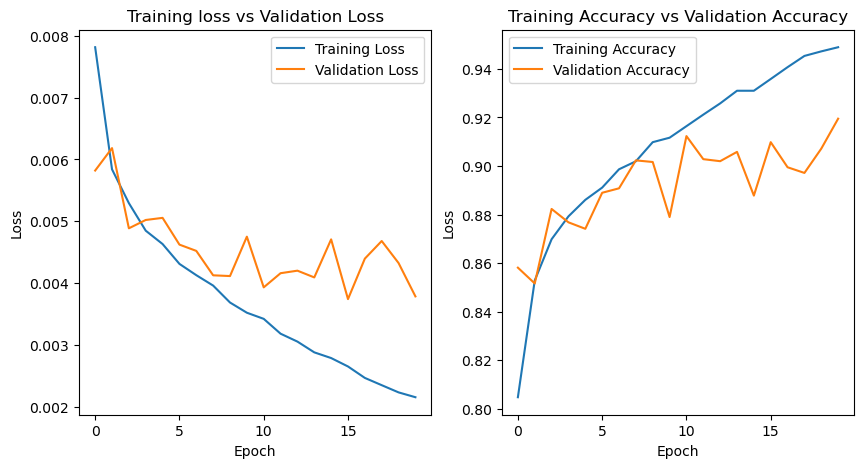

In [33]:
plots(train_loss_list3, train_acc_list3, val_loss_list3, val_acc_list3)

### Early Stopping model

In [34]:
# Add Early stopping criteria to the training function
def es_train_model(num_epochs,model,train_loader,val_loader, criterion, optimizer, device, patience=3):
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    start_time  = time.time()
    
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        print("Training Model...")
        running_loss = 0.0
        train_correct = 0.0
        train_total = 0
        model.train()
        for i, data in enumerate(train_loader, 0):
            # Get the inputs and labels from the dataloader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l2_loss = 0
            for param in model.parameters():
                l2_loss += torch.sum(param.pow(2))
            loss += l2_reg * l2_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, train_predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (train_predicted == labels).sum().item()

        # Validation

        val_running_loss = 0
        val_acc = 0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move validation inputs and labels to device
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_running_loss += loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (val_predicted == val_labels).sum().item()
                        
        val_running_loss = val_running_loss/len(val_loader.dataset)
        val_loss_list.append(val_running_loss)
        val_acc = correct/total
        val_acc_list.append(val_acc)
        running_loss = running_loss/len(train_loader.dataset)
        train_loss_list.append(running_loss)
        train_acc = train_correct/train_total
        train_acc_list.append(train_acc)

        print(f'Epoch : {epoch}, train_loss = {running_loss}, train_acc = {round(train_acc*100,3)}, val_loss = {val_running_loss}, val_acc = {round(val_acc*100,3)}')
        
        # Early stopping
        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Validation loss did not improve for {patience} epochs. Stopping training early...')
                break
    
    # return running_loss,train_acc,val_running_loss,val_acc
    end_time  = time.time()
    elapsed_time = end_time - start_time
    print("Training time in seconds : ",elapsed_time)
    return  train_acc_list, val_loss_list, val_acc_list


In [37]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = BL2AlexNet(num_classes=3).to(device)
l2_reg = 0.0001
optimizer = optim.Adam(model4.parameters(),lr=0.0001, weight_decay=l2_reg)
num_epochs = 20

In [38]:
train_loss_list4, train_acc_list4, val_loss_list4, val_acc_list4 = es_train_model(num_epochs,model4,train_loader,val_loader, criterion, optimizer, device, patience=3)


Training Model...
Epoch : 0, train_loss = 0.027031702319780984, train_acc = 80.013, val_loss = 0.006651704912384351, val_acc = 83.3
Training Model...
Epoch : 1, train_loss = 0.024284042527278265, train_acc = 85.3, val_loss = 0.006567340038716793, val_acc = 84.033
Training Model...
Epoch : 2, train_loss = 0.022686584075291952, train_acc = 86.804, val_loss = 0.005007010720670223, val_acc = 87.05
Training Model...
Epoch : 3, train_loss = 0.021249869048595427, train_acc = 87.629, val_loss = 0.004575589579840501, val_acc = 88.983
Training Model...
Epoch : 4, train_loss = 0.01984850800037384, train_acc = 88.421, val_loss = 0.004636279529581467, val_acc = 89.0
Training Model...
Epoch : 5, train_loss = 0.018507590937117735, train_acc = 89.183, val_loss = 0.0046332288620372615, val_acc = 89.183
Training Model...
Epoch : 6, train_loss = 0.017224627991517385, train_acc = 89.708, val_loss = 0.0040887640292445815, val_acc = 90.417
Training Model...
Epoch : 7, train_loss = 0.01591574925929308, train

In [39]:
test_accuracy4 = test_model(model4, test_loader, device)


Test Accuracy =  89.68333333333334


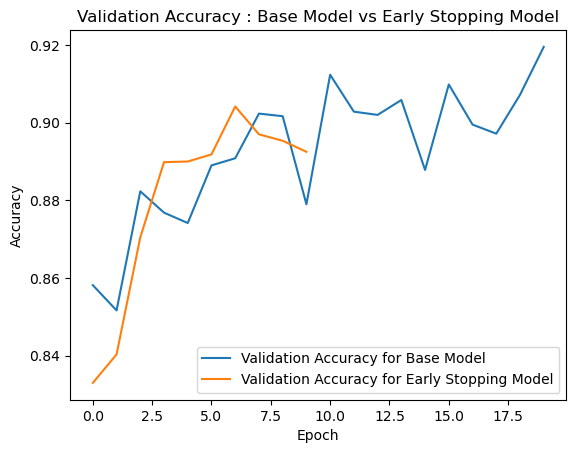

In [40]:
plt.plot(val_acc_list3, label='Validation Accuracy for Base Model')
plt.plot(val_acc_list4, label='Validation Accuracy for Early Stopping Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Validation Accuracy : Base Model vs Early Stopping Model")
plt.legend()
# plt.ylim([0.5, 1.0])
# plt.xlim([0,20])

### List of Test Accuracies

In [43]:
print(f'Original AlexNet test acc : {round(orig_test_accuracy,3)}%')
print(f'Model 1 (0.01 LR) test acc : {round(test_accuracy1,3)}%')
print(f'Model 2 (Dropout 0.4) test acc : {round(test_accuracy2,3)}%')
print(f'Model 3 (Batch Norm + L2 Reg) test acc : {round(test_accuracy3,3)}%')
print(f'Model 4 (Early Stopping) test acc : {round(test_accuracy4,3)}%')

Original AlexNet test acc : 90.683%
Model 1 (0.01 LR) test acc : 89.917%
Model 2 (Dropout 0.4) test acc : 91.517%
Model 3 (Batch Norm + L2 Reg) test acc : 91.567%
Model 4 (Early Stopping) test acc : 89.683%


## Part 4 - Google SVHN Dataset

### Based on above test accuracies, our base model is Model 3

In [44]:
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader, ConcatDataset

In [45]:
transform = transforms.Compose([transforms.ToTensor()])

svhn_train = SVHN(root = 'C:/Users/ShilpaG/Documents/Kartheek', split = 'train', download = True, transform=transform)
svhn_test = SVHN(root = 'C:/Users/ShilpaG/Documents/Kartheek', split = 'test', download = True, transform=transform)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

### Calculate mean and std of the dataset

In [46]:
# Calculate the mean and standard deviation of the dataset for all three channels
mean = 0.0
std = 0.0
num_samples = len(dataset)

for x, _ in dataset:
    # Sum over all channels and all pixels
    mean += torch.mean(x, dim=(1,2))
    std += torch.std(x, dim=(1,2))

# Divide by the number of samples to get the final mean and standard deviation
mean /= num_samples
std /= num_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([-0.0776, -0.0729, -0.0646])
Std: tensor([1.0674, 1.0480, 1.0278])


### Use the mean and std to transform the dataset

In [47]:
norm_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[-0.0776, -0.0729, -0.0646], std=[1.0674, 1.0480, 1.0278])])

# Load train and test datasets
train_data = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=norm_transform)
test_data = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=norm_transform)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)
val_loader= torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [49]:
print("Length of training set : ", len(train_data))
print("Length of test set : ", len(test_data))


Length of training set :  73257
Length of test set :  26032


### Visualization 1: Count the number of examples in each class

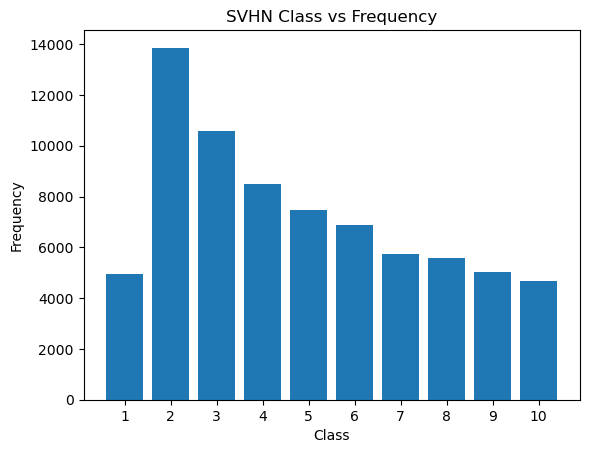

In [52]:

class_counts = np.bincount(train_data.labels, minlength=10)

# Plot the class vs frequency
plt.bar(np.arange(10), class_counts)
plt.xticks(np.arange(10), labels=np.arange(1, 11))
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('SVHN Class vs Frequency')
plt.show()



### Visualization 2: Choose a randome image and plot a histogram of pixel intensities

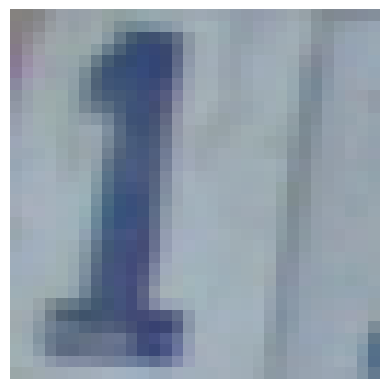

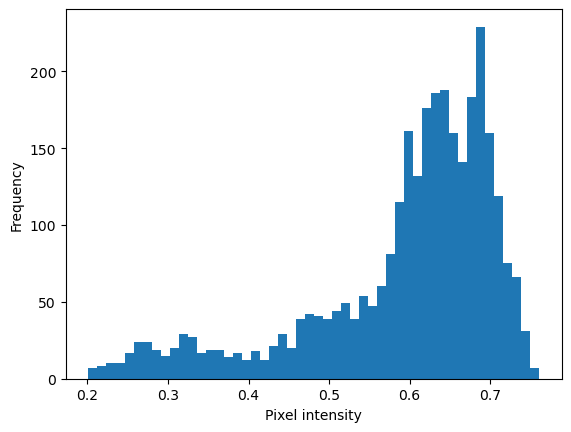

In [56]:
# VIS2

# Choose a random image from the training set
img_idx = np.random.randint(len(train_data))
img, _ = train_data[img_idx]

# Plot the image
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()

# Plot the pixel intensity histogram
plt.hist(img.numpy().flatten(), bins=50)
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
plt.show()

### Visualization 3: Choose a random image and plot a scatterplot of pixels

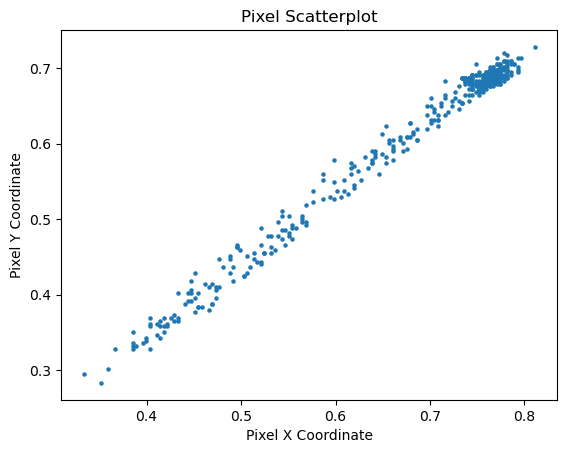

In [61]:
#VIS3
# Choose a random image from the dataset
img, label = train_data[np.random.randint(len(train_data))]

# Reshape the image into a 2D array
pixels = np.reshape(img, (img.shape[0], -1))

# Create the scatterplot
plt.scatter(pixels[0], pixels[1], s=5)

# Set the title and axis labels
plt.title("Pixel Scatterplot")
plt.xlabel("Pixel X Coordinate")
plt.ylabel("Pixel Y Coordinate")

# Display the plot
plt.show()

### Visualization 4: Print random images along with class labels

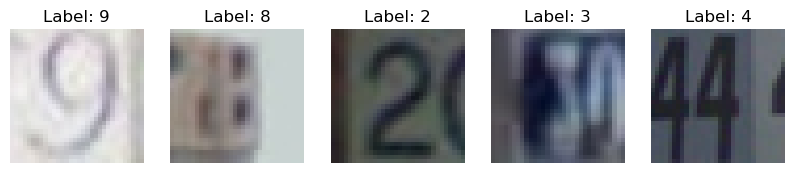

In [63]:
#VIS4

# Choose 5 random indices
indices = np.random.choice(len(train_data), size=5, replace=False)

# Plot the images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, idx in enumerate(indices):
    img, label = svhn_train[idx]
    axs[i].imshow(np.transpose(img, (1, 2, 0)))
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()

### Modify the base model to accept 32x32 images

In [69]:
# Modify the base AlexNet Model to accept 32x32 images
class SVHN_AlexNet(nn.Module):
    def __init__(self, num_classes=10, reg_lambda=0.01):
        super(SVHN_AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.reg_lambda = reg_lambda

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        # L2 regularization
        l2_reg = torch.tensor(0.).to(x.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        
        return x - self.reg_lambda * l2_reg


In [70]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
svhn_model = SVHN_AlexNet(num_classes=10).to(device)
optimizer = optim.Adam(svhn_model.parameters(),lr=0.0001, weight_decay=0.0001)
num_epochs = 20

In [71]:
svhn_train_loss_list, svhn_train_acc_list, svhn_val_loss_list, svhn_val_acc_list = train_model(num_epochs,svhn_model,train_loader,val_loader, criterion, optimizer, device)


Training Model...
Epoch : 0, train_loss = 0.013992666799498761, train_acc = 70.224, val_loss = 0.006705968566902884, val_acc = 86.966
Training Model...
Epoch : 1, train_loss = 0.006440148535774513, train_acc = 87.092, val_loss = 0.00479469191570341, val_acc = 91.088
Training Model...
Epoch : 2, train_loss = 0.005243916650980913, train_acc = 89.729, val_loss = 0.003816669067418284, val_acc = 92.916
Training Model...
Epoch : 3, train_loss = 0.004595073626676603, train_acc = 91.103, val_loss = 0.0036024339426968294, val_acc = 93.458
Training Model...
Epoch : 4, train_loss = 0.004088176246888336, train_acc = 92.1, val_loss = 0.003493489854131638, val_acc = 93.681
Training Model...
Epoch : 5, train_loss = 0.0037364788423212563, train_acc = 92.859, val_loss = 0.0032796267788976286, val_acc = 94.119
Training Model...
Epoch : 6, train_loss = 0.0034756295362432183, train_acc = 93.434, val_loss = 0.003281046612504194, val_acc = 94.103
Training Model...
Epoch : 7, train_loss = 0.00319753590291996

In [72]:
svhn_test_accuracy = test_model(svhn_model, test_loader, device)


Test Accuracy =  94.72956361401353


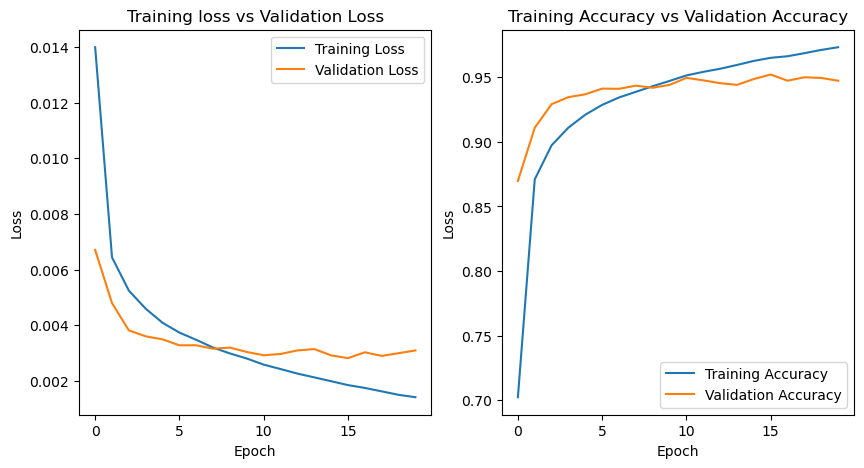

In [73]:
plots(svhn_train_loss_list, svhn_train_acc_list, svhn_val_loss_list, svhn_val_acc_list)

### Data Augmentation

In [74]:
# Data Augmentation and concatenation

aug_transform1 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0776, -0.0729, -0.0646], std=[1.0674, 1.0480, 1.0278])
    
])

aug_transform2 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0776, -0.0729, -0.0646], std=[1.0674, 1.0480, 1.0278])
    
])

aug_transform3 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.0776, -0.0729, -0.0646], std=[1.0674, 1.0480, 1.0278])
    
])


aug_svhn_train1 = SVHN(root = './data', split = 'train', download = True, transform=aug_transform1)
final_dataset1 = ConcatDataset([svhn_train,aug_svhn_train1])

aug_svhn_train2 = SVHN(root = './data', split = 'train', download = True, transform=aug_transform2)
final_dataset2 = ConcatDataset([svhn_train,aug_svhn_train2])

aug_svhn_train3 = SVHN(root = './data', split = 'train', download = True, transform=aug_transform3)
final_dataset3 = ConcatDataset([svhn_train,aug_svhn_train3])

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


### Model 1 : Random rotation and Random crop

In [75]:
print(f'Trainset length : {len(final_dataset1)}, Testset length : {len(svhn_test)}')

Trainset length : 146514, Testset length : 26032


In [76]:
train_loader = torch.utils.data.DataLoader(final_dataset1, batch_size=64, shuffle=True, num_workers=4)

In [79]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
svhn_model1 = SVHN_AlexNet(num_classes=10).to(device)
optimizer = optim.Adam(svhn_model1.parameters(),lr=0.0001, weight_decay=0.0001)
num_epochs = 10

In [80]:
svhn_train_loss_list1, svhn_train_acc_list1, svhn_val_loss_list1, svhn_val_acc_list1 = train_model(num_epochs,svhn_model1,train_loader,val_loader, criterion, optimizer, device)


Training Model...
Epoch : 0, train_loss = 0.013384995252955388, train_acc = 71.73, val_loss = 0.004948849343885361, val_acc = 90.562
Training Model...
Epoch : 1, train_loss = 0.006380113695205696, train_acc = 87.282, val_loss = 0.0037978866395724283, val_acc = 92.801
Training Model...
Epoch : 2, train_loss = 0.00523047663008724, train_acc = 89.779, val_loss = 0.0031737324540728282, val_acc = 94.272
Training Model...
Epoch : 3, train_loss = 0.004617124686937119, train_acc = 91.05, val_loss = 0.0029248271170962364, val_acc = 94.783
Training Model...
Epoch : 4, train_loss = 0.004121425710311856, train_acc = 92.087, val_loss = 0.0029861326638515296, val_acc = 94.753
Training Model...
Epoch : 5, train_loss = 0.003790929442704369, train_acc = 92.712, val_loss = 0.0026033224699175592, val_acc = 95.502
Training Model...
Epoch : 6, train_loss = 0.003487768488961006, train_acc = 93.341, val_loss = 0.0026204544129911937, val_acc = 95.294
Training Model...
Epoch : 7, train_loss = 0.003267543992968

In [81]:
svhn_test_accuracy1 = test_model(svhn_model1, test_loader, device)


Test Accuracy =  95.65918869084204


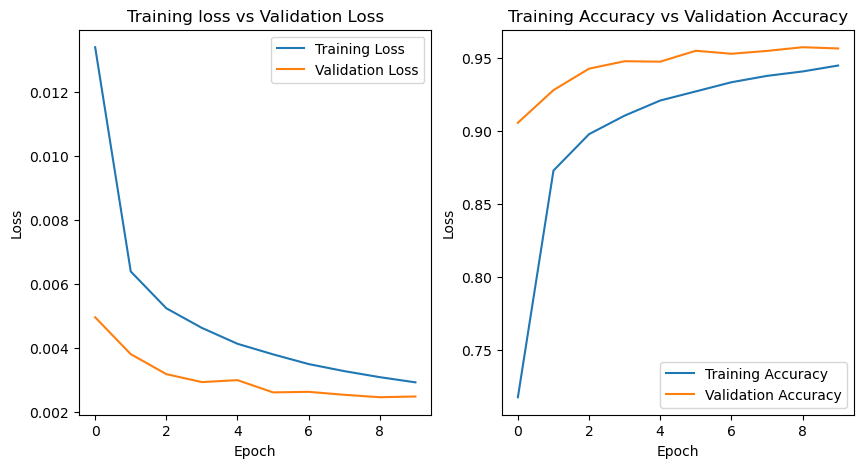

In [82]:
plots(svhn_train_loss_list1, svhn_train_acc_list1, svhn_val_loss_list1, svhn_val_acc_list1)

### Model 2 : Color Jitter and Random Horizontal Flip

In [83]:
train_loader = torch.utils.data.DataLoader(final_dataset2, batch_size=64, shuffle=True, num_workers=4)

In [84]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
svhn_model2 = SVHN_AlexNet(num_classes=10).to(device)
optimizer = optim.Adam(svhn_model2.parameters(),lr=0.0001, weight_decay=0.0001)
num_epochs = 10

In [85]:
svhn_train_loss_list2, svhn_train_acc_list2, svhn_val_loss_list2, svhn_val_acc_list2 = train_model(num_epochs,svhn_model2,train_loader,val_loader, criterion, optimizer, device)

Training Model...
Epoch : 0, train_loss = 0.01367848608159465, train_acc = 70.851, val_loss = 0.005962170508232817, val_acc = 88.48
Training Model...
Epoch : 1, train_loss = 0.006668816796588795, train_acc = 86.457, val_loss = 0.004608648368938796, val_acc = 91.222
Training Model...
Epoch : 2, train_loss = 0.005430912607841286, train_acc = 89.23, val_loss = 0.003849431869791982, val_acc = 92.936
Training Model...
Epoch : 3, train_loss = 0.004673157323809398, train_acc = 90.803, val_loss = 0.0035035059161681154, val_acc = 93.489
Training Model...
Epoch : 4, train_loss = 0.00417643150577519, train_acc = 91.869, val_loss = 0.0036203961877510657, val_acc = 93.143
Training Model...
Epoch : 5, train_loss = 0.0038023475881596835, train_acc = 92.696, val_loss = 0.0032672855255898654, val_acc = 94.027
Training Model...
Epoch : 6, train_loss = 0.0034659209379959556, train_acc = 93.281, val_loss = 0.003229815709485072, val_acc = 94.053
Training Model...
Epoch : 7, train_loss = 0.00320032923478608

In [86]:
svhn_test_accuracy2 = test_model(svhn_model2, test_loader, device)

Test Accuracy =  94.3799938537185


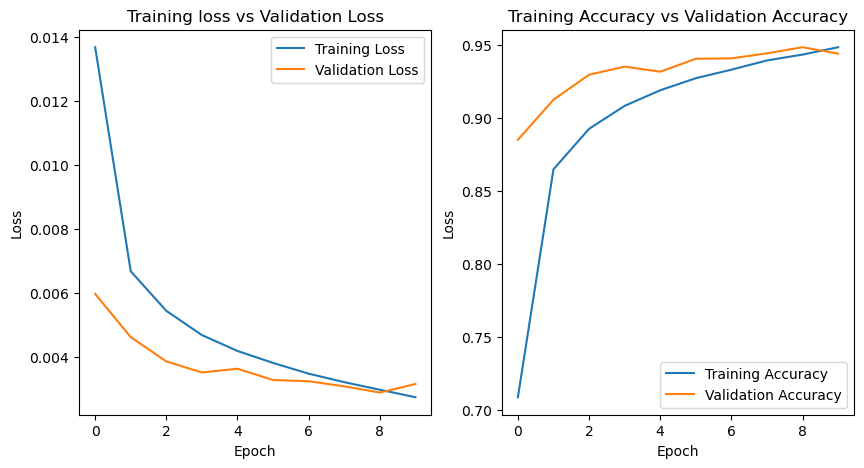

In [87]:
plots(svhn_train_loss_list2, svhn_train_acc_list2, svhn_val_loss_list2, svhn_val_acc_list2)

### Model 3 : Random rotation, Random crop, Color Jitter, Random Horizontal Flip

In [88]:
train_loader = torch.utils.data.DataLoader(final_dataset3, batch_size=64, shuffle=True, num_workers=4)

In [89]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
svhn_model3 = SVHN_AlexNet(num_classes=10).to(device)
optimizer = optim.Adam(svhn_model3.parameters(),lr=0.0001, weight_decay=0.0001)
num_epochs = 10

In [90]:
svhn_train_loss_list3, svhn_train_acc_list3, svhn_val_loss_list3, svhn_val_acc_list3 = train_model(num_epochs,svhn_model3,train_loader,val_loader, criterion, optimizer, device)

Training Model...
Epoch : 0, train_loss = 0.016602328300934967, train_acc = 64.156, val_loss = 0.0059018712261830215, val_acc = 88.418
Training Model...
Epoch : 1, train_loss = 0.00839040353423341, train_acc = 82.756, val_loss = 0.004588611132465875, val_acc = 91.122
Training Model...
Epoch : 2, train_loss = 0.00681491160711463, train_acc = 86.337, val_loss = 0.0037723429560874255, val_acc = 93.059
Training Model...
Epoch : 3, train_loss = 0.006002516774070763, train_acc = 87.964, val_loss = 0.0035272548445995575, val_acc = 93.447
Training Model...
Epoch : 4, train_loss = 0.005423511016461946, train_acc = 89.254, val_loss = 0.003218316042466065, val_acc = 94.096
Training Model...
Epoch : 5, train_loss = 0.0050347831375794315, train_acc = 90.07, val_loss = 0.0031447846617906846, val_acc = 94.299
Training Model...
Epoch : 6, train_loss = 0.004649567678329707, train_acc = 90.928, val_loss = 0.003304448576338392, val_acc = 93.712
Training Model...
Epoch : 7, train_loss = 0.0044010376415397

In [91]:
svhn_test_accuracy3 = test_model(svhn_model3, test_loader, device)

Test Accuracy =  94.90242778119237


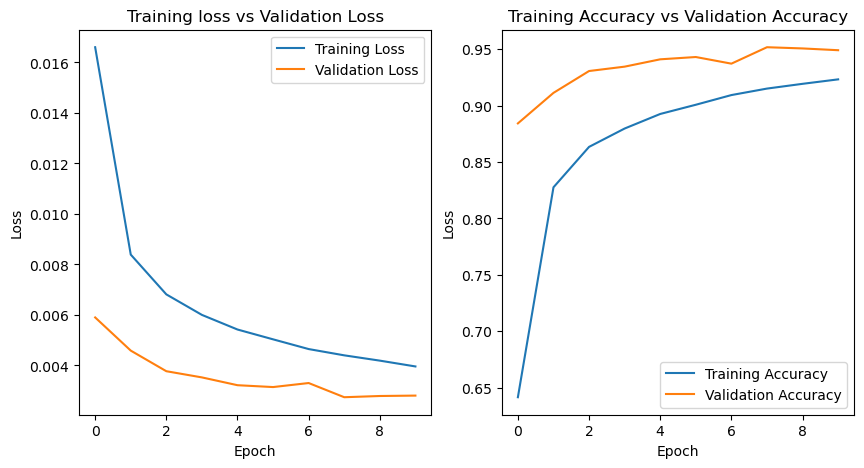

In [92]:
plots(svhn_train_loss_list3, svhn_train_acc_list3, svhn_val_loss_list3, svhn_val_acc_list3)

### List of Test Accuracies

In [93]:
print(f'Test acc without Data Aug : {round(svhn_test_accuracy,3)}%')
print(f'Model 1 Test Acc : {round(svhn_test_accuracy1,3)}%')
print(f'Model 2 Test Acc : {round(svhn_test_accuracy2,3)}%')
print(f'Model 3 Test Acc : {round(svhn_test_accuracy3,3)}%')


Test acc without Data Aug : 94.73%
Model 1 Test Acc : 95.659%
Model 2 Test Acc : 94.38%
Model 3 Test Acc : 94.902%


## References
 - https://pytorch.org/hub/pytorch_vision_alexnet/
 - https://pytorch.org/vision/main/_modules/torchvision/models/alexnet.html
 - https://goodboychan.github.io/python/datacamp/pytorch/deep_learning/2020/07/29/02-Using-Convolutional-Neural-Networks-in-PyTorch.html
 - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html